In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys

PATH_YANGNET = '/Users/lauradriscoll/Documents/code/yangnet/training' #'/home/laura/code/yangnet/training'
sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
# from tensorflow.python.ops import parallel_for as pfor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from brewer2mpl import qualitative
import math

from task import generate_trials, rule_name, rules_dict, Trial
from network import Model, get_perf
import tools

import numpy as np
from scipy import linalg as LA
import datetime

In [5]:
def dim_compute(X):
    train = X# X[0:int(X.shape[0]/2),:]
    test = X# X[int((X.shape[0]/2)):X.shape[0],:]

    pca = PCA()
    pca.fit(train)
    ev_train = pca.explained_variance_
    ev_test = np.var(pca.transform(test),axis=0)
    return ev_test

def gen_trials_from_model_dir(model_dir,rule, batch_size =500):
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
# # # #         model.cell._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
#         params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial
        trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size =batch_size, delay_fac =1)
    return trial  

def load_X_from_model_dir(model_dir,trial):
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
#         model.cell._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        hparams = model.hp
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        # run model
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        x = np.transpose(h_tf,(2,1,0))
        X = np.reshape(x,(x.shape[0],-1))
    return X, h_tf    #return orthogonal complement of hidden unit activity to ouput projection matrix


In [55]:
batch_size = 60
tasks = np.concatenate((range(6),[11,12],range(16,20)))
rule_set = rules_dict['all']
fp_fix_all = None
model_n = 0

model_dir = '/home/laura/code/yangnet/training/data/lowDin/all/0'
model_dir = os.path.join('/Users/lauradriscoll/Documents/data/rnn/multitask/lowD/combos/most',str(model_n))
file_name = 'Multitask Network lowDin fix map' + '_' + str(model_n) 
        

for task in tasks:
    rule = rules_dict['all'][task]
    trial = gen_trials_from_model_dir(model_dir,rule,batch_size=batch_size)
    _, h = load_X_from_model_dir(model_dir,trial)
    fp_fix = np.squeeze(h[trial.epochs['fix1'][1]-1,:,:])
    if fp_fix_all is None:
        fp_fix_all = fp_fix
        theta_all = np.arctan2(trial.y[-1,:,1],trial.y[-1,:,2])
    else:
        fp_fix_all = np.concatenate((fp_fix_all, fp_fix), axis=0)
        theta_all = np.concatenate((theta_all, np.arctan2(trial.y[-1,:,1],trial.y[-1,:,2])), axis=0)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/combos/most/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/combos/most/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/combos/most/0/model.ckpt
Model restored from file: /Users/laura

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/combos/most/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/combos/most/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/combos/most/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/combos/most/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float3

In [65]:
from sklearn.metrics.pairwise import euclidean_distances

def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

print(check_symmetric(euclidean_distances(X_center)))


False


In [56]:
from sklearn.datasets import load_digits
from sklearn.manifold import MDS

cmap=plt.get_cmap('tab20')
X = fp_fix_all.astype(np.float64)
row_means = np.mean(X, axis=0)
row_var = np.var(X, axis=0)
X_center = X - np.tile(row_means,(X.shape[0],1))
X_ball = np.true_divide(X - np.tile(row_means,(X.shape[0],1)), np.tile(row_var,(X.shape[0],1)))

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X_center)

fig = plt.figure(figsize=(12, 6),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(1,2,1)
for r in range(len(tasks)):
    task = tasks[r]
    c = cmap(r/max(tasks))
    ind = range((r-1)*batch_size,r*batch_size)
    plt.plot(X_transformed[ind,0],X_transformed[ind,1],'o',c = c)
    plt.text(X_transformed[ind[0],0],X_transformed[ind[0],1],rule_set[task],fontsize=16,fontweight='bold',
        bbox={'facecolor':c, 'alpha':0.5, 'pad':2})

plt.xlabel('MDS1')
plt.ylabel('MDS2')
    
    
ax = fig.add_subplot(1,2,2)
plt.scatter(X_transformed[:,0],X_transformed[:,1],s=20,c=theta_all,cmap = 'rainbow')
plt.xlabel('MDS1')
plt.ylabel('MDS2')

plt.savefig('cosyne/lowDin_mds/' + file_name + '.svg')
plt.show()

/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


ValueError: Array must be symmetric

In [103]:
print(ind)


[360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419]


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/lowDin/all/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/lowDin/all/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/lowDin/all/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/lowDin/all/0/model.ckpt


/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'Time in Trial')

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


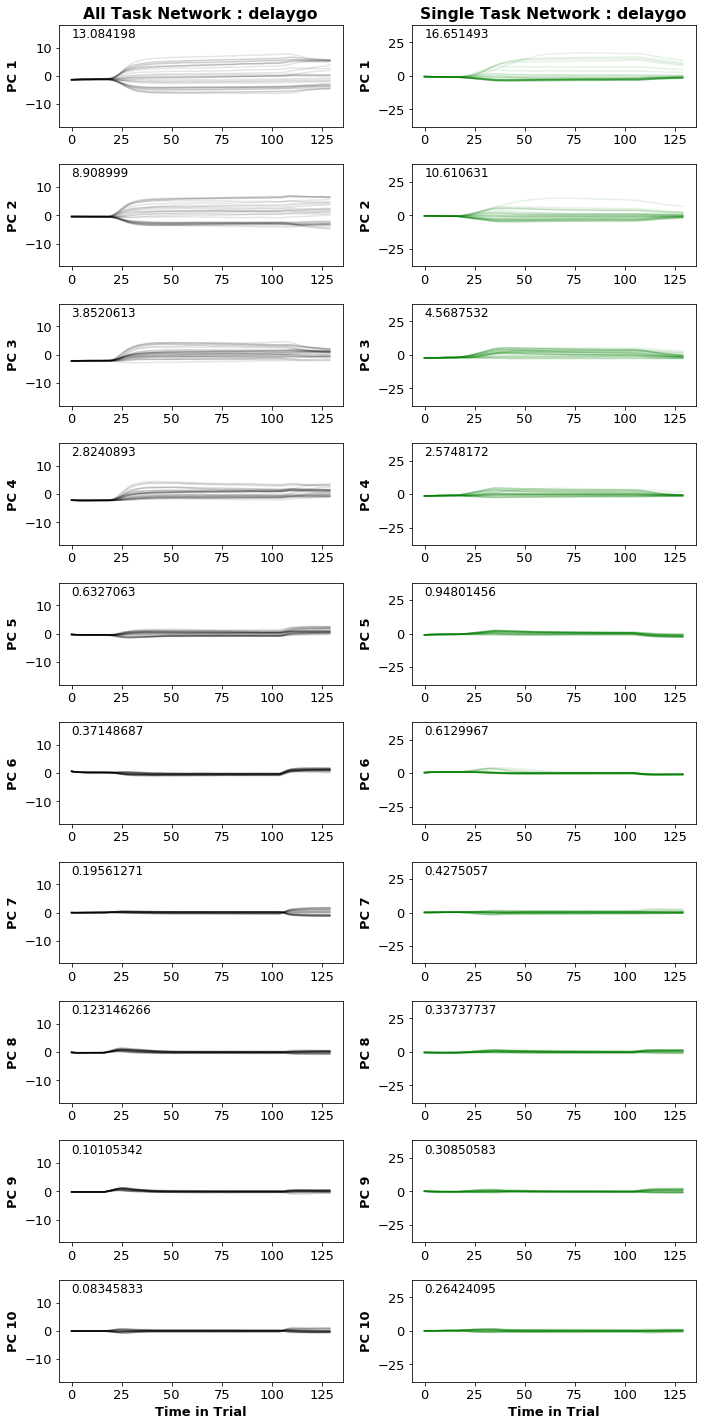

In [4]:
model_n = 0
n_models = 1
n_units = 256
n_pcs = 50
rule = rules_dict['all'][2]
n_pcs_plot = 10

model_dir = '/home/laura/code/yangnet/training/data/lowDin/all/0'
model_dir_single = '/home/laura/code/yangnet/training/data/lowDin/delaygo/0'

trial = gen_trials_from_model_dir(model_dir,rule)
trial_dur = trial.y.shape[0]
n_trials = trial.y.shape[2]

X_multi, _ = load_X_from_model_dir(model_dir,trial)
X_single, _ = load_X_from_model_dir(model_dir_single,trial)

FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(10, 20),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 13})
    
#multi model
row_means = np.mean(X_multi, axis=1)
X_center = X_multi - row_means.reshape(X_multi.shape[0],1)

pcar = PCA(n_components=n_pcs)
pcar.fit(X_center.T)
X_low = pcar.transform(X_center.T)
pca = PCA()
X_pc_multi = pca.fit_transform(X_low)
X_ev_multi = pca.explained_variance_  

#single model
row_means = np.mean(X_single, axis=1)
X_center = X_single - row_means.reshape(X_single.shape[0],1)

pcar = PCA(n_components=n_pcs)
pcar.fit(X_center.T)
X_low = pcar.transform(X_center.T)
pca = PCA()
X_pc_single = pca.fit_transform(X_low)
X_ev_single = pca.explained_variance_  

for t_num in range(30):
    ind = range((t_num)*trial_dur,(t_num+1)*trial_dur)
    
    for pc in range(n_pcs_plot):
        
        ax = fig.add_subplot(n_pcs_plot,2,2*pc+1)
        plt.plot(X_pc_multi[ind,pc],'-k',alpha=.1)
        ax.set_ylim(-2*np.max(abs(X_pc_multi)) , 2*np.max(abs(X_pc_multi)))     
        
        ax = fig.add_subplot(n_pcs_plot,2,2*pc+2)
        plt.plot(X_pc_single[ind,pc],'-g',alpha=.1)
        ax.set_ylim(-2*np.max(abs(X_pc_single)) , 2*np.max(abs(X_pc_single)))        
                
        if t_num==0:
            ax = fig.add_subplot(n_pcs_plot,2,2*pc+1)   
            plt.text(0, 1.5*np.max(X_pc_multi), X_ev_multi[pc], fontsize=12)        
            ax.set_ylabel('PC '+ str(pc+1), fontweight=FONT_WEIGHT)
            
            ax = fig.add_subplot(n_pcs_plot,2,2*pc+2)   
            plt.text(0, 1.5*np.max(X_pc_single), X_ev_single[pc], fontsize=12)        
            ax.set_ylabel('PC '+ str(pc+1), fontweight=FONT_WEIGHT)

ax = fig.add_subplot(n_pcs_plot,2,1)
ax.set_title('All Task Network : ' + rule, fontweight=FONT_WEIGHT)
ax = fig.add_subplot(n_pcs_plot,2,2)
ax.set_title('Single Task Network : ' + rule, fontweight=FONT_WEIGHT)

ax = fig.add_subplot(n_pcs_plot,2,2*n_pcs_plot-1)
ax.set_xlabel('Time in Trial', fontweight=FONT_WEIGHT)
ax = fig.add_subplot(n_pcs_plot,2,2*n_pcs_plot)
ax.set_xlabel('Time in Trial', fontweight=FONT_WEIGHT)

In [19]:
np.shape(X_multi)

(256, 59000)

(0, 1)

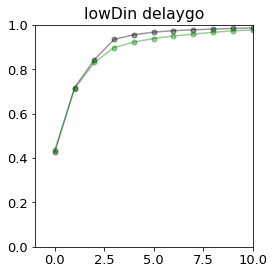

In [6]:
fig = plt.figure(figsize=(4, 4),tight_layout=True,facecolor='white')
ax = fig.add_subplot(1,1,1)

plt.plot(np.cumsum(X_ev_multi)/np.sum(X_ev_multi),'-ok',alpha=.4,MarkerSize=5)
plt.plot(np.cumsum(X_ev_single)/np.sum(X_ev_single),'-og',alpha=.4,MarkerSize=5)
            
ax.set_title('lowDin ' + rule)
ax.set_xlim(-1, 10)
ax.set_ylim(0, 1)

In [66]:
batch_size = 200
rule_set = rules_dict['all'][11:12]
fp_fix_all = None

model_dir = '/home/laura/code/yangnet/training/data/lowDin/all/0'

for task in rule_set:
    trial = gen_trials_from_model_dir(model_dir,task,batch_size=batch_size)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/lowDin/all/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/lowDin/all/0/model.ckpt


In [67]:
print(rule_set)

['delaydm1']


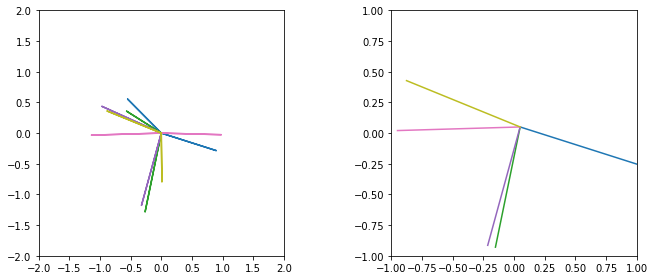

In [68]:
def make_stim_vec(yx):
    loc = np.arctan2(yx[:,0], yx[:,1])
    strength = LA.norm(yx,axis=-1)    
    return strength*np.cos(loc),strength*np.sin(loc)

fig = plt.figure(figsize=(12, 4),tight_layout=True,facecolor='white')
cmap=plt.get_cmap('tab10')
num_trials = 5

for t in range(num_trials):
    c = cmap(t/num_trials)
    x1vec = make_stim_vec(trial.x[:,t,1:3])
    x2vec = make_stim_vec(trial.x[:,t,3:5])
    yvec = make_stim_vec(trial.y[:,t,1:])     
    
    ax = fig.add_subplot(1,2,1)
    plt.plot(x1vec[0],x1vec[1],c = c)
    plt.plot(x2vec[0],x2vec[1],c = c)
    plt.axis('square')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
    ax = fig.add_subplot(1,2,2)
    plt.plot(yvec[0],yvec[1],c = c)
    plt.axis('square')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

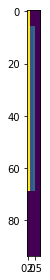

In [60]:
fig = plt.figure(figsize=(12, 4),tight_layout=True,facecolor='white')
plt.imshow(trial.x[:,0,0:5])

In [72]:
model = Model(model_dir)
with tf.Session() as sess:
    model.restore()
        
print(trial.mods)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/lowDin/all/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/lowDin/all/0/model.ckpt


AttributeError: 'Trial' object has no attribute 'mods'

In [62]:
print(trial.x[:,t,1:3])

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 [-0.5569174  -0.78713757]
 